<a href="https://colab.research.google.com/github/Toan02Ky-UIT/ComputerVisionProject/blob/main/LBP%2BSVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
DATA_PATH = "/content/drive/MyDrive/Vehicle_dataset/Vehicles"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import cv2
import os
from skimage import feature
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import pickle
from tqdm import tqdm

In [ ]:
class LocalBinaryPatterns:
    def __init__(self, numPoints=24, radius=3):
        """
        numPoints: số điểm lân cận
        radius: bán kính
        """
        self.numPoints = numPoints
        self.radius = radius

    def describe(self, image, eps=1e-7):
        """
        Tính toán LBP histogram cho ảnh
        """
        # Tính LBP
        lbp = feature.local_binary_pattern(image,
                                          self.numPoints,
                                          self.radius,
                                          method="uniform")

        # Tính histogram
        (hist, _) = np.histogram(lbp.ravel(),
                                bins=np.arange(0, self.numPoints + 3),
                                range=(0, self.numPoints + 2))

        # Chuẩn hóa histogram
        hist = hist.astype("float")
        hist /= (hist.sum() + eps)

        return hist

In [ ]:
def load_dataset(data_path, image_size=(128, 128)):
    """
    Load dataset từ thư mục
    Structure: data_path/class_name/images.jpg
    """
    data = []
    labels = []

    # Lấy danh sách các class (thư mục con)
    classes = [d for d in os.listdir(data_path)
               if os.path.isdir(os.path.join(data_path, d))]

    print(f"Found {len(classes)} classes: {classes}")

    for class_name in classes:
        class_path = os.path.join(data_path, class_name)
        image_files = [f for f in os.listdir(class_path)
                      if f.endswith(('.jpg', '.jpeg', '.png'))]

        print(f"Loading {len(image_files)} images from {class_name}...")

        for img_file in tqdm(image_files):
            img_path = os.path.join(class_path, img_file)

            try:
                # Đọc ảnh
                image = cv2.imread(img_path)

                if image is None:
                    continue

                # Resize
                image = cv2.resize(image, image_size)

                # Chuyển sang grayscale
                gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

                data.append(gray)
                labels.append(class_name)

            except Exception as e:
                print(f"Error loading {img_path}: {e}")
                continue

    return np.array(data), np.array(labels)

In [ ]:
def extract_features(images, lbp_descriptor):
    """
    Trích xuất LBP features cho tất cả ảnh
    """
    features = []

    print("Extracting LBP features...")
    for image in tqdm(images):
        hist = lbp_descriptor.describe(image)
        features.append(hist)

    return np.array(features)

In [ ]:
# Load dataset
print("=" * 50)
print("LOADING DATASET")
print("=" * 50)
images, labels = load_dataset(DATA_PATH, image_size=(128, 128))

print(f"\nTotal images loaded: {len(images)}")
print(f"Image shape: {images[0].shape}")
print(f"Unique labels: {np.unique(labels)}")

# Initialize LBP descriptor
lbp_desc = LocalBinaryPatterns(numPoints=24, radius=3)

# Extract features
print("\n" + "=" * 50)
print("EXTRACTING FEATURES")
print("=" * 50)
features = extract_features(images, lbp_desc)
print(f"Feature vector shape: {features.shape}")

# Encode labels
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)

# Split dataset: 80% train, 10% valid, 10% test
# First split: 80% train, 20% temp (will be split into valid and test)
X_train, X_temp, y_train, y_temp = train_test_split(
    features, labels_encoded,
    test_size=0.2,
    random_state=42,
    stratify=labels_encoded
)

# Second split: split temp into 50-50 (which is 10% valid, 10% test of original)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_temp
)

print(f"\nTraining samples: {len(X_train)} ({len(X_train)/len(features)*100:.1f}%)")
print(f"Validation samples: {len(X_valid)} ({len(X_valid)/len(features)*100:.1f}%)")
print(f"Testing samples: {len(X_test)} ({len(X_test)/len(features)*100:.1f}%)")
print(f"Total samples: {len(features)}")

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

# Train SVM with GridSearch
print("\n" + "=" * 50)
print("TRAINING SVM")
print("=" * 50)

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.001, 0.01],
    'kernel': ['rbf', 'linear']
}

svm = SVC(random_state=42)

# GridSearch với validation set
grid_search = GridSearchCV(svm, param_grid, cv=5,
                          scoring='accuracy',
                          n_jobs=-1,
                          verbose=2)

grid_search.fit(X_train_scaled, y_train)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Best model
best_model = grid_search.best_estimator_

# Evaluate on validation set
y_valid_pred = best_model.predict(X_valid_scaled)
valid_accuracy = accuracy_score(y_valid, y_valid_pred)
print(f"\nValidation Accuracy: {valid_accuracy:.4f}")

LOADING DATASET
Found 7 classes: ['Ships', 'Cars', 'Auto Rickshaws', 'Planes', 'Trains', 'Bikes', 'Motorcycles']
Loading 800 images from Ships...


100%|██████████| 800/800 [00:49<00:00, 16.24it/s]


Loading 789 images from Cars...


100%|██████████| 789/789 [00:10<00:00, 76.36it/s] 


Loading 741 images from Auto Rickshaws...


100%|██████████| 741/741 [00:11<00:00, 67.36it/s] 


Loading 775 images from Planes...


100%|██████████| 775/775 [00:15<00:00, 48.68it/s]


Loading 800 images from Trains...


100%|██████████| 800/800 [00:13<00:00, 60.46it/s]


Loading 800 images from Bikes...


100%|██████████| 800/800 [00:10<00:00, 76.15it/s]


Loading 799 images from Motorcycles...


100%|██████████| 799/799 [00:09<00:00, 86.48it/s] 



Total images loaded: 5504
Image shape: (128, 128)
Unique labels: ['Auto Rickshaws' 'Bikes' 'Cars' 'Motorcycles' 'Planes' 'Ships' 'Trains']

EXTRACTING FEATURES
Extracting LBP features...


100%|██████████| 5504/5504 [01:01<00:00, 89.22it/s]

Feature vector shape: (5504, 26)

Training samples: 4403 (80.0%)
Validation samples: 550 (10.0%)
Testing samples: 551 (10.0%)
Total samples: 5504

TRAINING SVM
Fitting 5 folds for each of 32 candidates, totalling 160 fits



Best parameters: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Best cross-validation score: 0.5603

Validation Accuracy: 0.6000



EVALUATION ON TEST SET

Test Accuracy: 0.5717

Classification Report:
                precision    recall  f1-score   support

Auto Rickshaws       0.58      0.46      0.51        74
         Bikes       0.75      0.64      0.69        80
          Cars       0.42      0.46      0.44        79
   Motorcycles       0.57      0.49      0.53        80
        Planes       0.74      0.65      0.69        78
         Ships       0.55      0.71      0.62        80
        Trains       0.48      0.59      0.53        80

      accuracy                           0.57       551
     macro avg       0.58      0.57      0.57       551
  weighted avg       0.58      0.57      0.57       551



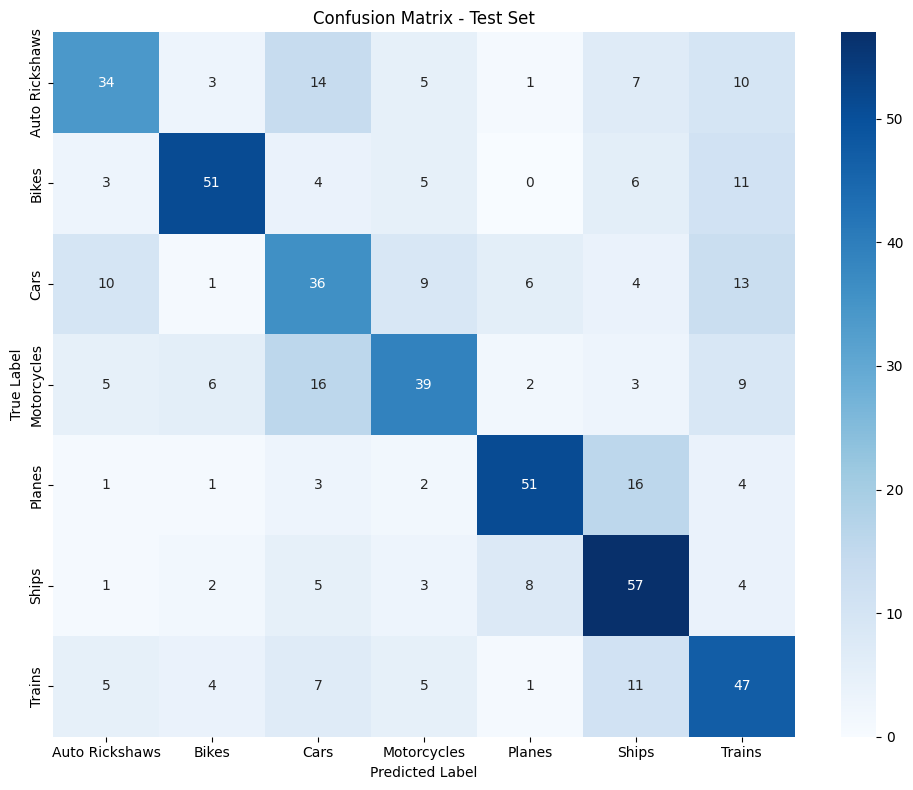


Per-class Accuracy:
Auto Rickshaws: 0.4595
Bikes: 0.6375
Cars: 0.4557
Motorcycles: 0.4875
Planes: 0.6538
Ships: 0.7125
Trains: 0.5875

SUMMARY
Training samples: 4403 - Not evaluated (used for training)
Validation samples: 550 - Accuracy: 0.6000
Test samples: 551 - Accuracy: 0.5717


In [ ]:
# Predictions on TEST set
print("\n" + "=" * 50)
print("EVALUATION ON TEST SET")
print("=" * 50)

y_pred = best_model.predict(X_test_scaled)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nTest Accuracy: {accuracy:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred,
                          target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=le.classes_,
           yticklabels=le.classes_)
plt.title('Confusion Matrix - Test Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Per-class accuracy
print("\nPer-class Accuracy:")
for i, class_name in enumerate(le.classes_):
    class_acc = cm[i, i] / cm[i].sum() if cm[i].sum() > 0 else 0
    print(f"{class_name}: {class_acc:.4f}")

# Summary of all sets
print("\n" + "=" * 50)
print("SUMMARY")
print("=" * 50)
print(f"Training samples: {len(X_train)} - Not evaluated (used for training)")
print(f"Validation samples: {len(X_valid)} - Accuracy: {valid_accuracy:.4f}")
print(f"Test samples: {len(X_test)} - Accuracy: {accuracy:.4f}")

In [9]:
def predict_vehicle(image_path, model, scaler, le, lbp_desc):
    """
    Predict loại xe từ ảnh
    """
    # Load và preprocess ảnh
    image = cv2.imread(image_path)
    image = cv2.resize(image, (128, 128))
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Extract LBP features
    features = lbp_desc.describe(gray)
    features = features.reshape(1, -1)

    # Scale features
    features_scaled = scaler.transform(features)

    # Predict
    prediction = model.predict(features_scaled)[0]
    proba = model.decision_function(features_scaled)[0]

    # Decode label
    label = le.inverse_transform([prediction])[0]

    # Visualize
    plt.figure(figsize=(8, 6))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f'Predicted: {label}\nConfidence: {proba:.2f}')
    plt.axis('off')
    plt.show()

    return label, proba

# Test prediction
# test_image = '/path/to/test/image.jpg'
# predict_vehicle(test_image, best_model, scaler, le, lbp_desc)